### Creating inserts for 75 biggest cities (max 1 per country) and airports
10 biggest cities will have a primary and secondary airport, the rest will have only one airport

In [1]:
import pandas as pd

In [2]:
citiesDF = pd.read_csv('data/worldcities.csv').sort_values(by=['population'], ascending=False)
n = 75
maxPerCountry = 1
#biggest cities will have 2 airports
maxPer2Airports = 10

In [3]:
citiesDF

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140
...,...,...,...,...,...,...,...,...,...,...,...
9469,Wé,We,-20.9000,167.2667,New Caledonia,NC,NCL,Province Îles,admin,NaN,1540672599
9470,Preševo,Presevo,42.3067,21.6500,Serbia,RS,SRB,Preševo,admin,NaN,1688970219
9471,Bujanovac,Bujanovac,42.4667,21.7667,Serbia,RS,SRB,Bujanovac,admin,NaN,1688743477
9472,Kitamilo,Kitamilo,0.2222,33.2061,Uganda,UG,UGA,Buvuma,admin,NaN,1800610172


In [4]:
#dict for keeping track of cities per country
countryCount = {}
i = 0
j = 0
loc = "sqlScripts"
with open(f"{loc}/generateCities.sql", "w") as fileC, open(f"{loc}/generateAirports.sql", "w") as fileA:
    fileC.write('BEGIN\n')
    fileA.write('BEGIN\n')
    for idx, row in citiesDF.iterrows():
        country = row['country']
        if country not in countryCount.keys():
            countryCount[country] = 0
        if countryCount[country] < maxPerCountry:
            countryCount[country] += 1
            city = row['city_ascii'].replace("'","")
            fileC.write(f"INSERT INTO CITIES VALUES({i}, '{city}', '{country}', {row['lat']}, {row['lng']});\n")
            fileA.write(f"INSERT INTO AIRPORTS VALUES ({j}, 'Main Airport {city}', {i});\n")
            j += 1
            if i < maxPer2Airports:
                fileA.write(f"INSERT INTO AIRPORTS VALUES ({j}, 'Secondary Airport {city}', {i});\n")
                j += 1
            i += 1
            if i == n:
                break
    fileC.write('COMMIT;\n EXCEPTION WHEN OTHERS THEN\n RAISE;\n END;\n /')
    fileA.write('COMMIT;\n EXCEPTION WHEN OTHERS THEN\n RAISE;\n END;\n /')

### Creating inserts for planes ownership
Initially there are 4 airlines and 5 airplane models. We will create n random airline-airplaneModel ownership for each airline, where n will be chosen randomly from normal distribution $N(mean, std)$

In [5]:
import numpy as np
import random

In [6]:
#number of airlines
numAirlines = 4
#number of airplane models
numModels = 5
#normal distribution params
mean = 100
std = 10
counter = 0

with open(f"{loc}/generateAirplanes.sql", "w") as file:
    file.write('BEGIN\n')
    for i in range(numAirlines):
        #how many planes the airline owns
        owns = max(1, int(np.random.normal(mean, std)))
        for j in range(owns):
            modelId = random.randint(0, numModels - 1)
            file.write(f"INSERT INTO AIRPLANES VALUES ({counter}, {i}, {modelId});\n")
            counter += 1
    file.write('COMMIT;\n EXCEPTION WHEN OTHERS THEN\n RAISE;\n END;\n /')

### Creating inserts for flights
All flights will take place in January 2030

In [7]:
from geopy import distance
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#retrieve data about cities and airports from the files that we have previously generated
retCities = pd.DataFrame(columns=['id', 'latitude', 'longitude'])
retAirports = pd.DataFrame(columns=['id', 'idCity'])

with open(f"{loc}/generateCities.sql", 'r') as file:
    for line in file:
        if line[0] != 'I':
            #line is not an insert
            continue
        inputs = line.split(',')
        idx = int(inputs[0][inputs[0].find('(')+1:])
        lat = float(inputs[-2][1:])
        lon = float(inputs[-1][1:-3])
        retCities = retCities.append({'id': idx, 'latitude': lat, 'longitude': lon}, ignore_index=True)
        
with open(f"{loc}/generateAirports.sql", 'r') as file:
    for line in file:
        if line[0] != 'I':
            #line is not an insert
            continue
        inputs = line.split(',')
        idx = int(inputs[0][inputs[0].find('(')+1:])
        idxCity = int(inputs[-1][1:-3])
        retAirports = retAirports.append({'id': idx, 'idCity': idxCity}, ignore_index=True)

In [9]:
#minimum distance is ~6 km, we don't want to create flights for such short distances
distances = []
mini = float('inf')
maxi = 0
c = (0,0)
for i in range(n):
    for j in range(i+1,n):
        x = retCities.iloc[[i]].to_numpy()[0]
        y = retCities.iloc[[j]].to_numpy()[0]
        d = distance.distance((x[1], x[2]), (y[1], y[2])).km
        distances.append(d)
        if mini > d:
            mini = d
            c = (i,j)

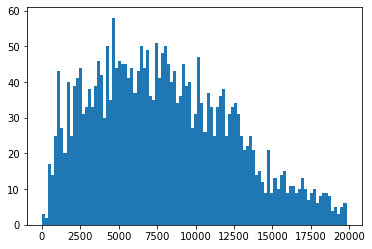

In [10]:
#distribution of distances between cities in our dataset
plt.hist(distances, bins=100)
plt.show()

In [11]:
#we want different distances to be taken with different probability 
#very short flights are not so likely, as well as very long flights
#we sample 2 airports randomly, compute distance between them and decide if we create a flight between them
bounds = [1000, 2000, 4000, 7000, 10000]
#probabs adjusted empirically
probabs = [0, 0.9, 1, 0.2, 0.1, 0]

In [12]:
def giveProbab(b, p, x):
    #return p[i] such b[i-1] < x <= b[i], where b[-1] = -inf and b[n] = inf
    #b must be ascending
    i = 0
    n = len(b)
    while i < n and x > b[i]:
        i += 1
    return p[i]

In [13]:
def getDistanceAirports(id1, id2):
    idCity1 = retAirports.iloc[[id1]].to_numpy()[0][1]
    idCity2 = retAirports.iloc[[id2]].to_numpy()[0][1]
    city1 = x = retCities.iloc[[idCity1]].to_numpy()[0]
    city2 = x = retCities.iloc[[idCity2]].to_numpy()[0]
    return distance.distance((city1[1], city1[2]), (city2[1], city2[2])).km

In [14]:
def simulateOneAirplane(dateFormat, startDate, endDate):
    """
    Inputs:
    - dateFormat 
    - startDate - starting date for our simulation
    - endDate - date after which we don't want any flight to begin
    """
    #initial airport
    idxStart = random.randint(0,len(retAirports)-1)
    currentTime = datetime.strptime(startDate, dateFormat)
    endTime = datetime.strptime(endDate, dateFormat)
    
    #num of airports
    n = len(retAirports)
    res = []
    
    #create flights untill end date
    while currentTime < endTime:
        
        #index of arrival airport
        idxEnd = random.randint(0, n-1)
        
        #distance of flight
        dist = getDistanceAirports(idxStart, idxEnd)
        probab = giveProbab(bounds, probabs, dist)
        
        if random.random() > probab:
            #resample
            continue
            
        #average speed 600km/h
        flightHours = max(0.7, np.random.normal(1, 0.1)) * dist / 600  
        hours = int(flightHours)
        mins = int((flightHours - hours) * 60)
        arrivalTime = currentTime + timedelta(hours=hours, minutes=mins)
        
        #price is coorelated with distance
        price = 100 + int(max(0, np.random.normal(1.8, 1.5)) * dist / 10)
        price -= price % 10
        
        #convert to suitable formats
        dateDeparture = datetime.strftime(currentTime, dateFormat)
        dateArrival = datetime.strftime(arrivalTime, dateFormat)
        res.append((price, dateDeparture, dateArrival, idxStart, idxEnd))
        
        #we add at least 15 mins to next flight departure time
        currentTime = arrivalTime + timedelta(minutes=max(15, int(np.random.normal(60, 30))))
        #our new departure airport is previous destination airport
        idxStart = idxEnd
    return res

In [15]:
idx = 0
with open(f"{loc}/generateFlights.sql", "w") as file:
    file.write('BEGIN\n')
    #for every plane
    for i in range(counter):
        flights = simulateOneAirplane("%d-%b-%y %I.%M.%S %p", "01-Jan-30 12.0.0 AM", "31-Jan-30 11.59.0 PM")
        for flight in flights:
            columns = "(id, planeId, price_per_ticket, date_dept, date_arr, airport_dept, airport_arr)"
            values = f"({idx}, {i}, {flight[0]}, '{flight[1]}', '{flight[2]}',{flight[3]}, {flight[4]})"
            file.write(f"INSERT INTO FLIGHTS {columns} VALUES {values};\n")
            idx += 1
        if i % 10 == 0:
            print(f"{i+1}/{counter}")
    file.write('COMMIT;\n EXCEPTION WHEN OTHERS THEN\n RAISE;\n END;\n /')

1/385
11/385
21/385
31/385
41/385
51/385
61/385
71/385
81/385
91/385
101/385
111/385
121/385
131/385
141/385
151/385
161/385
171/385
181/385
191/385
201/385
211/385
221/385
231/385
241/385
251/385
261/385
271/385
281/385
291/385
301/385
311/385
321/385
331/385
341/385
351/385
361/385
371/385
381/385
